# DMRG: 1D Fermi-Hubbard Model

In this quickstart guide, we apply pyTTN to evaluate the ground state energy of the 1D Fermi-Hubbard Model using a matrix product state representation for the wavefunction.  We consider the Hamiltonian

$$ \hat{H} = -t \sum_{i\sigma} \left(\hat{c}_{i\sigma}^\dagger \hat{c}_{i+1\sigma} + h.c.\right) + U\sum_i \hat{n}_{i\uparrow }\hat{n}_{i\downarrow} - \mu\sum_{i\sigma} \hat{n}_{i\sigma }$$

where we will consider the case of $t = 1$, $U = 4$, $\mu = U/2$, and a chain consisting of $N=100$ sites.

### Contents


1. [Importing the Package](#importing-the-package)

2. [Setting up the System and Hamiltonian](#setting-up-the-system-and-hamiltonian)

3. [Preparing the Initial Wavefunction](#preparing-the-initial-wavefunction)

4. [Preparing the sop_operator Representation of the Hamiltonian](#preparing-the-sop_operator-hamiltonian)

5. [Setting up and Performing the DMRG Loop](#setting-up-and-performing-the-dmrg-loop)


### Importing the Package

We start by importing the required modules for this example

In [10]:
import os
os.environ['OMP_NUM_THREADS']='1'

import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

import pyttn
from pyttn.utils import visualise_tree

### Setting up the System and Hamiltonian

We start by setting up the `system_modes` object that tells pyTTN the type of operators to expect, and local Hilbert space dimension associated with each mode.  Here we have a total of $N=100$ Fermion sites, each with two spin degrees of Freedom.  In this example, we will work with a Fermion ordering of the form $\{1\uparrow, 1\downarrow, 2\uparrow, 2\downarrow, \dots, N\uparrow, N\downarrow \}$, and combine the two spin orbitals for each site into a physical degree of freedom.  

Within pyTTN, this can readily be done by setting the value of the system_modes object to be a composite mode as shown below:

In [11]:
# Define number of modes
Norb = 100
Nsorb = Norb*2

# Initialise system information variable as a set of N modes
sysinf = pyttn.system_modes(Norb)

# Specify that each mode is a two level system
for i in range(Norb):
    sysinf[i] = [pyttn.fermion_mode(), pyttn.fermion_mode()]

We now prepare the system Hamiltonian through the use of the `SOP` class.  This makes use of a string representation of the Hamiltonian, that is later converted into a form necessary for performing calculations.  For more details on the generation of operators see the [tutorial on operator generation](file/../operator_generation.ipynb).

Now when specifying the Hamiltonian, we need to be aware of the selected Fermion ordering.  Here we are using the ordering $\{1\uparrow, 1\downarrow, 2\uparrow, 2\downarrow, \dots, N\uparrow, N\downarrow \}$.

In [12]:
t = 1.0
U = 4.0
mu = U/2

#set up the system Hamiltonian
H = pyttn.SOP(Nsorb)

#add on the hopping terms
for i in range(Norb-1):

    #the hopping terms for up spins
    H += -t*(pyttn.fOP("cdag", 2*i)*pyttn.fOP("c", 2*(i+1)) + pyttn.fOP("cdag", 2*(i+1))*pyttn.fOP("c", 2*i))

    #the hopping terms for down spins
    H += -t*(pyttn.fOP("cdag", 2*i+1)*pyttn.fOP("c", 2*(i+1)+1) + pyttn.fOP("cdag", 2*(i+1)+1)*pyttn.fOP("c", 2*i+1))


#now add density-density interactions
for i in range(Norb):
    H += U*pyttn.fOP("n", 2*i)*pyttn.fOP("n", 2*i+1) - mu*(pyttn.fOP("n", 2*i) + pyttn.fOP("n", 2*i+1))


This has defined the Hamiltonian in terms of Fermionic operators.  In order to perform DMRG calculations, it is first necessary to encode this onto Pauli operators.  Within pyTTN, this can be done using a Jordan-Wigner mapping as follows, which introduces Jordan-wigner strings as required.

In [13]:
#finally we Jordan-Wigner map this operator.  In order to handle the fermion exchange statistics
H = H.jordan_wigner(sysinf)

### Preparing the Initial Wavefunction

We now prepare the initial wavefunction.  This requires a two-step process, first we define the tree topology to use for this calculation through the use of the `ntree` class (which for this example we choose to be an MPS), following which we construct the `ttn` object that actually represents the wavefunction.  In this example we intend to use a subspace expansion based in order to expand bond dimension throughout the DMRG loop.  In order to do this, we define an additional `ntree` object with the same structure but different values defining the maximum allowed dimension of any bond in the network.  For more details one the construct of tree topologies see the [tutorial on tree topologies](file/../tree_topologies.ipynb). 


In [14]:
# Initial bond dimension
chi = 4

#maximum bond dimension
chi_max = 128

# Vector of dimensions of the local Hilbert space in the physical nodes
dims = sysinf.mode_dimensions()

#now construct an ntree object storing the MPS topology using the ntreeBuilder class
topo = pyttn.ntreeBuilder.mps_tree(dims, chi)
capacity = pyttn.ntreeBuilder.mps_tree(dims, chi_max)

#now allocate the wavefunction object.  And allocate it so that each tensor is filled with random values
A = pyttn.ttn(topo, capacity, dtype=np.complex128)
A.random()

When creating the `ttn` object, tensors will be constructed with the sizes defined in `topo` but with enough space allocated to store the tensors defined in `capacity`.  

### Preparing the `sop_operator` Hamiltonian

Now before we are ready to set up and perform the DMRG loop, we first need to convert the Hamiltonian into a form that can be used to efficiently within the DMRG algorithm.  Within pyTTN, two formats are supported for the Hamiltonian:

1. the Sum-of-Product operator representation
2. the Hierarchical Sum-of-Product operator representation 

With the Sum-of-Product operator representation being the standard form used in ML-MCTDH calculations and the Hierarchical Sum-of-Product operator representation being equivalent to a sparse tensor representation of a Tree Tensor Network Operator.  Within pyTTN, both types of operator are handled with the same objects, namely the `sop_operator`.  The user can select between these two operator representations through the use of the compress variable with:

- `compress=False` leading to the construction of a Sum-of-Product operator
- `compress=True` leading to the construction of a Hierarchical Sum-of-Product operator.

By default calls to `sop_operator` will lead to the construction of Hierarchical Sum-of-Product operators.

In [15]:
h = pyttn.sop_operator(H, A, sysinf, compress=True)

### Setting up and Performing the DMRG Loop

Now we can have everything we need to set up all of the objects required to perform the DMRG loop.  Here we set up DMRG with the use of subspace expansion to expand bond dimensions throughout the update steps. Here we will do a coarse loop with a relatively low threshold for subspace expansion before performing a series of more, tightly converged steps.

In [16]:
#set up the DMRG sweeping object to 
sweep = pyttn.dmrg(A, h, krylov_dim = 8, expansion='subspace', subspace_krylov_dim=12, subspace_neigs=6)

#set up the subspace expansion parameters.  Here we expand bond dimension whenever a term in the 
#two-site energy variance (that is not captured within the single-site spaces) has singular value > threshold
#and do not use natural populations to determine whether to spawn additional basis functions.
threshold = [1e-2, 1e-2, 1e-2, 1e-3, 1e-3, 1e-4, 1e-4, 1e-4, 1e-4, 1e-6, 1e-6, 1e-8, 1e-8, 1e-8, 1e-8]
sweep.minimum_unoccupied=0

Now we perform the sweep setting the spawning threshold at each step in the loop

In [17]:
for i in range(len(threshold)):
    sweep.spawning_threshold = threshold[i]

    #perform the DMRG step
    sweep(A, h)

    #and print out the energy per site for the sweep
    print(i+1, np.real(sweep.E()/Norb), A.maximum_bond_dimension(), flush=True)

1 -2.555900950833639 8
2 -2.562434021508975 8
3 -2.5633760901371465 8
4 -2.5663149345530503 15
5 -2.567896751616524 19
6 -2.5688534906872316 26
7 -2.5695197142922286 31
8 -2.569725383078926 33
9 -2.569816876093405 35
10 -2.5695488009075067 45
11 -2.5696973727303756 54
12 -2.5695043282061643 65
13 -2.569844816476963 75
14 -2.5698344829848874 86
15 -2.569892704894183 98


Now finally, we will visualise what the subspace expansion scheme has done to the bond dimension of the TTN, using the `visualise_tree` function.

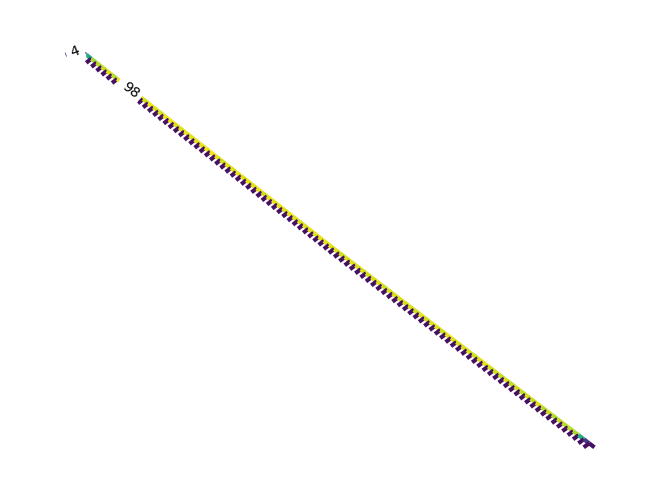

In [18]:
visualise_tree(A, bond_prop="bond dimension", node_size=0)
plt.show()